In [1]:
#https://fluent.docs.pyansys.com/version/stable/examples/00-fluent/DOE_ML.html#sphx-glr-examples-00-fluent-doe-ml-py

#Imports
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import ansys.fluent.core as pyfluent
from ansys.fluent.core import examples

In [2]:
#import the elbow file from ansys examples

import_filename = examples.download_file(
    "elbow.cas.h5",
    "pyfluent/examples/DOE-ML-Mixing-Elbow",
    save_path=os.getcwd(),
)

In [3]:
# Parameters + cache check (place BEFORE Fluent launch)

import json, hashlib
from pathlib import Path

# DOE parameters
coldVelArr = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
hotVelArr  = np.array([0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0])
iter_count = 200

# Anchor cache next to the downloaded case file to avoid CWD issues
base_dir = Path(import_filename).resolve().parent
cache_dir = (base_dir / "cache")
cache_dir.mkdir(parents=True, exist_ok=True)

cfg = {
    "coldVelArr": coldVelArr.tolist(),
    "hotVelArr": hotVelArr.tolist(),
    "iter_count": iter_count,
    "case": os.path.basename(import_filename),
}
cache_key  = hashlib.md5(json.dumps(cfg, sort_keys=True).encode()).hexdigest()[:8]
cache_path = cache_dir / f"resArr_{cache_key}.npz"

print(f"Working dir: {Path.cwd()}")
print(f"Case dir:     {base_dir}")
print(f"Expected cache: {cache_path}")

USE_CACHED = False
resArr = None

# Helper to list available caches
available = sorted(cache_dir.glob("resArr_*.npz"), key=lambda p: p.stat().st_mtime, reverse=True)
if cache_path.exists():
    ans = input(f"Cached results found ({cache_path.name}). Use cached results? [y/N]: ").strip().lower()
    if ans == "y":
        data = np.load(cache_path, allow_pickle=True)
        resArr = data["resArr"]
        USE_CACHED = True
        print("Using cached results.")
    else:
        print("Proceeding to run simulations.")
else:
    if available:
        print("Computed cache not found. Other caches available:")
        for i, pth in enumerate(available[:5], 1):
            print(f"  {i}. {pth.name}")
        ans = input("Use most recent available cache? [y/N]: ").strip().lower()
        if ans == "y":
            cache_path = available[0]
            data = np.load(cache_path, allow_pickle=True)
            resArr = data["resArr"]
            USE_CACHED = True
            print(f"Using cached results from {cache_path.name}.")
        else:
            print("No cache selected; running simulations.")
    else:
        print("No cache found; running simulations.")


Working dir: c:\Users\danny\OneDrive - University of Arkansas\Research\Learning\PyANSYS_ML
Case dir:     C:\Users\danny\OneDrive - University of Arkansas\Research\Learning\PyANSYS_ML
Expected cache: C:\Users\danny\OneDrive - University of Arkansas\Research\Learning\PyANSYS_ML\cache\resArr_386c9b16.npz
Computed cache not found. Other caches available:
  1. resArr_0c84b29c.npz
Using cached results from resArr_0c84b29c.npz.


In [4]:
# Boot Fluent only if needed
if not USE_CACHED:
    solver_session = pyfluent.launch_fluent(
        precision="double",
        processor_count=6,
        dimension=pyfluent.Dimension.THREE
    )
    print(solver_session.get_fluent_version())
else:
    print("Skipping Fluent launch (using cached results).")


Skipping Fluent launch (using cached results).


In [5]:
# Read the case file (only when running simulations)
if not USE_CACHED:
    solver_session.settings.file.read_case(file_name=import_filename)


In [6]:
# Design of experiments run (skipped if using cache)
if not USE_CACHED:
    resArr = np.zeros((coldVelArr.shape[0], hotVelArr.shape[0]))
    for idx1, coldVel in np.ndenumerate(coldVelArr):
        for idx2, hotVel in np.ndenumerate(hotVelArr):
            cold_inlet = solver_session.settings.setup.boundary_conditions.velocity_inlet["cold-inlet"]
            cold_inlet.momentum.velocity.value = coldVel

            hot_inlet = solver_session.settings.setup.boundary_conditions.velocity_inlet["hot-inlet"]
            hot_inlet.momentum.velocity.value = hotVel

            solver_session.settings.solution.initialization.initialization_type = "standard"
            solver_session.settings.solution.initialization.standard_initialize()
            solver_session.settings.solution.run_calculation.iterate(iter_count=iter_count)

            res_tui = solver_session.scheme.exec((
                "(ti-menu-load-string "
                '"/report/surface-integrals/mass-weighted-avg outlet () '
                'temperature no")',
            ))
            resArr[idx1][idx2] = float(res_tui.split()[-1])

    # Save cache
    np.savez(cache_path,
             resArr=resArr,
             coldVelArr=coldVelArr,
             hotVelArr=hotVelArr,
             iter_count=iter_count,
             case_path=import_filename)
    print(f"Saved results to {cache_path}")
else:
    print("Loaded resArr from cache.")


Loaded resArr from cache.


In [7]:
# Exit Fluent (only if we launched it)
if not USE_CACHED:
    solver_session.exit()


In [8]:
#%pip install -U nbformat plotly
#import importlib, _plotly_utils.optional_imports as opt, plotly.io._renderers as _r; importlib.reload(opt); importlib.reload(_r)

In [9]:
# Plot response surface


fig = go.Figure(data=[go.Surface(z=resArr, x=coldVelArr, y=hotVelArr)])

fig.update_layout(
    title={
        "text": "Mixing Elbow Response Surface",
        "y": 0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)

fig.update_layout(
    scene=dict(
        xaxis_title="Cold Inlet Vel (m/s)",
        yaxis_title="Hot Inlet Vel (m/s)",
        zaxis_title="Outlet Temperature (K)",
    ),
    width=600,
    height=600,
    margin=dict(l=80, r=80, b=80, t=80),
)
fig.show()

In [33]:
# Prepare data for ML model

coldVelList = []
hotVelList = []
resultList = []

for i in range(resArr.shape[0]):
    for j in range(resArr.shape[1]):
        coldVelList.append(coldVelArr[i])
        hotVelList.append(hotVelArr[j])
        resultList.append(resArr[i, j])

tempDict = {"coldVel": coldVelList, "hotVel": hotVelList, "Result": resultList}

df = pd.DataFrame(tempDict)

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [34]:
# Build raw feature matrices and train/test split; define pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Raw features and target
X = df[["coldVel", "hotVel"]].values
y = df["Result"].values

# Holdout split for final report
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
X_train = train_set[["coldVel", "hotVel"]].values
y_train = train_set["Result"].values
X_test = test_set[["coldVel", "hotVel"]].values
y_test = test_set["Result"].values

# End-to-end pipeline: poly -> scale -> ridge
pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42)),
])


In [35]:
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold, cross_validate
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=2)


def fit_and_predict(model):
    """Cross-validate the full pipeline and report holdout metrics."""
    # Robust CV on entire dataset with preprocessing inside the pipeline
    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = cross_validate(
        model,
        X,
        y,
        scoring={
            "r2": "r2",
            "rmse": "neg_root_mean_squared_error",
            "mae": "neg_mean_absolute_error",
        },
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
    )
    print()
    print("Cross-Validation (RepeatedKFold) Summary:")
    print("R2:   mean=%.3f std=%.3f" % (scores["test_r2"].mean(), scores["test_r2"].std()))
    print("RMSE: mean=%.3f" % (-scores["test_rmse"].mean()))
    print("MAE:  mean=%.3f" % (-scores["test_mae"].mean()))

    # Fit on train split and evaluate on holdout
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    print()
    print("Coefficient Of Determination")
    print("Train Data R2 Score: %0.3f" % (r2_score(y_train, train_predictions)))
    print("Test Data R2 Score: %0.3f" % (r2_score(y_test, test_predictions)))

    residuals = test_predictions - y_test
    print()
    print("Predictions - Ground Truth (Kelvin): ", residuals[:10])

    # Save combined outputs
    com_train_set = train_set.copy()
    com_test_set = test_set.copy()
    com_train_set["Result"] = train_predictions.tolist()
    com_train_set["Set"] = ["Train"] * train_predictions.shape[0]
    com_test_set["Result"] = test_predictions.tolist()
    com_test_set["Set"] = ["Test"] * test_predictions.shape[0]
    df_combined = pd.concat([com_train_set, com_test_set])
    df_combined.to_csv(os.path.join(os.getcwd(), "PyFluent_Output.csv"), header=True, index=False)

    # Parity plots
    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(121)
    sns.regplot(x=y_train, y=train_predictions, color="g")
    plt.title("Train Data", fontsize=16)
    plt.xlabel("Ground Truth", fontsize=12)
    plt.ylabel("Predictions", fontsize=12)

    fig.add_subplot(122)
    sns.regplot(x=y_test, y=test_predictions, color="g")
    plt.title("Unseen Data", fontsize=16)
    plt.xlabel("Ground Truth", fontsize=12)
    plt.ylabel("Predictions", fontsize=12)

    plt.tight_layout()
    plt.show()



Cross-Validation (RepeatedKFold) Summary:
R2:   mean=0.905 std=0.042
RMSE: mean=0.653
MAE:  mean=0.526

Coefficient Of Determination
Train Data R2 Score: 0.945
Test Data R2 Score: 0.819

Predictions - Ground Truth (Kelvin):  [ 1.01 -0.54 -0.53 -0.46  0.63  0.91  0.68  0.51  0.05  0.96]


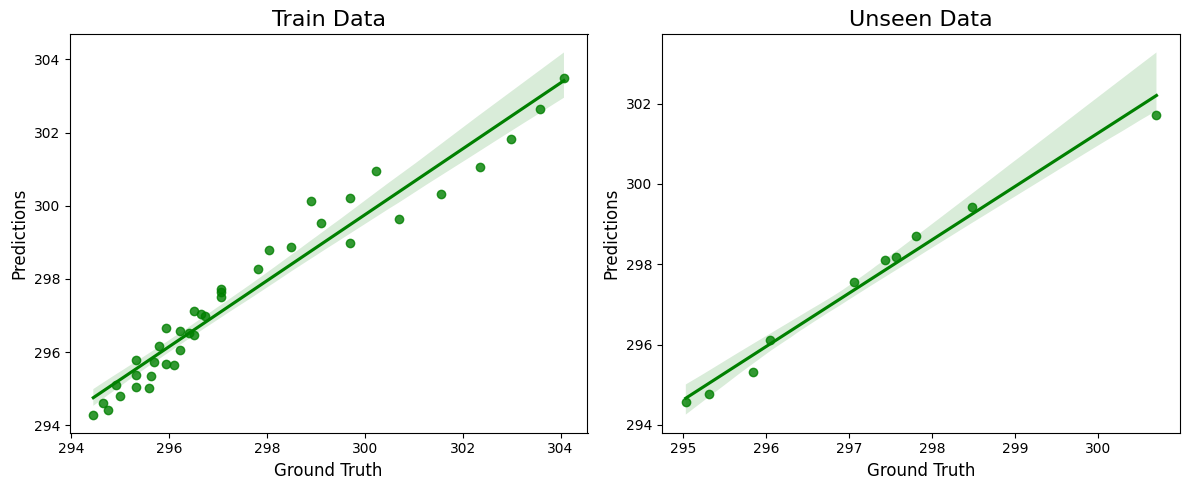

In [36]:
# Use the end-to-end pipeline (poly + scaler + ridge)
model = pipe
fit_and_predict(model)
